# Amplitude damping channel

In [88]:
from sympy import I, sqrt, symbols, exp, cos, sin, Symbol, Add, Matrix, sqrt, pi
from sympy.physics.quantum import TensorProduct as ox

theta, psi = symbols(r"\theta, \phi", real=True)
p = Symbol(r"p", positive=True, real=True)

dpsi = Matrix([0, cos(theta), exp(I * psi) * sin(theta), 0])

M_0 = Matrix([[1, 0], [0, sqrt(1-p)]])
M_1 = Matrix([[0, sqrt(p)], [0, 0]])

rho_ab = Add(*[ox(m_u, m_v) * (dpsi * dpsi.H) * ox(m_u.H, m_v.H) for m_u in [M_0, M_1] for m_v in [M_0, M_1]])

rho_ab

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2,                                                                      0,                                                                       0, 0],
[                                  0,                      sqrt(1 - p)*cos(\theta)**2*conjugate(sqrt(1 - p)), sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)), 0],
[                                  0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)),                       sqrt(1 - p)*sin(\theta)**2*conjugate(sqrt(1 - p)), 0],
[                                  0,                                                                      0,                                                                       0, 0]])

# Experiment

In [1]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler as PrimitiveSampler
from qiskit.circuit import Clbit, ClassicalRegister, Parameter
from qiskit_aer import AerProvider
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix, partial_trace, concurrence
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Sampler
from qiskit.visualization import array_to_latex, plot_state_city
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from math import pi, asin, sqrt, acos

def polarization(density_matrix: DensityMatrix) -> int:
    s1 = 2 * density_matrix.data[0, 0].real - 1
    s2 = 2 * density_matrix.data[0, 1].real
    s3 = -2 * density_matrix.data[0, 1].imag
    return LA.norm([s1, s2, s3])

# Build circuit

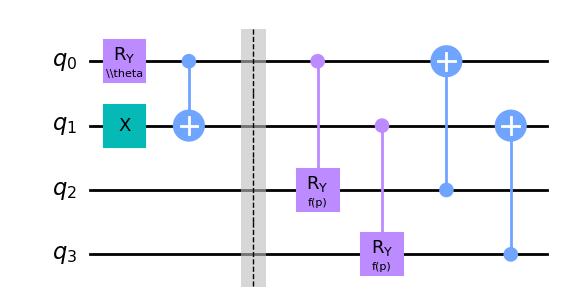

In [7]:
def build_circuit(v=0, t: int = None, p: int = None) -> QuantumCircuit:
    p_t = Parameter(r"\\theta")
    p_p = Parameter(r"f(p)")
    qc = None
    if v == 0:
        qc = QuantumCircuit(4)
        qc.ry(p_t, 0)
        qc.x(1)
        qc.cx(0, 1)

        qc.barrier()

        qc.cry(p_p, 0, 2)
        qc.cx(2, 0)

        qc.cry(p_p, 1, 3)
        qc.cx(3, 1)
    elif v == 1:
        qc = QuantumCircuit(3)
        qc.ry(p_p, 2)
        qc.cry(p_t, 2, 0)
        qc.cx(2, 1)
        qc.cx(0, 1)
    else:
        raise Exception("Undefined circuit version")

    if t is not None and p is not None:
        qc = qc.assign_parameters(
            {p_t: t, p_p: 2 * asin(sqrt(p)) if v == 0 else 2 * acos(sqrt(p))}
        )

    return qc


qc = build_circuit(v=0)
qc.draw("mpl")

# Simulation results

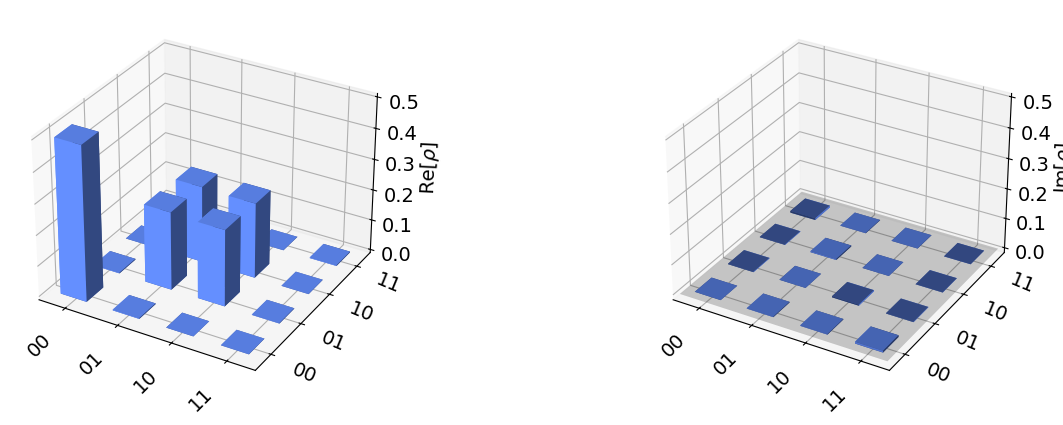

In [5]:
qc = build_circuit(v=0, t=pi / 2, p=0.5)
backend = AerProvider().get_backend("aer_simulator")
st = StateTomography(qc, measurement_indices=(0, 1))
stdata = st.run(backend, shots=10000).block_for_results()
state_result = stdata.analysis_results("state")
# array_to_latex(state_result.value)
plot_state_city(state_result.value)

/tmp/ipykernel_591494/454956511.py:47: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt((1 - p) ** 2 - (pol - p) ** 2)


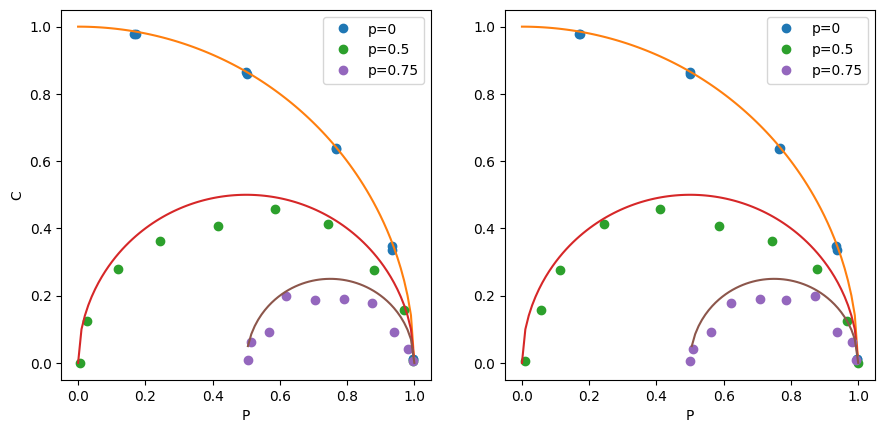

In [54]:
backend = AerProvider().get_backend("aer_simulator")
fig, axes = plt.subplots(1, 2)
# ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = axes
(ax1, ax2) = axes
i = 0
angles = np.linspace(0, pi, 10)
for p in [0, 0.5, 0.75]:
    pol0_values = []
    con0_values = []
    pol1_values = []
    con1_values = []
    for t in angles:
        qc = build_circuit(v=0, t=t, p=p)

        st = StateTomography(qc, measurement_indices=(0, 1))
        stdata = st.run(backend, shots=10000).block_for_results()
        state_result = stdata.analysis_results("state").value
        # state_result = partial_trace(DensityMatrix(qc), (2, 3))
        dm0 = partial_trace(state_result, (1,))
        dm1 = partial_trace(state_result, (0,))
        pol0 = polarization(dm0)
        pol1 = polarization(dm1)
        pol0_values.append(pol0)
        con0_values.append(concurrence(state_result))
        pol1_values.append(pol1)
        con1_values.append(concurrence(state_result))

    # C and P
    ax1.plot(pol0_values, con0_values, "o", label=f"p={p}")
    ax2.plot(pol1_values, con1_values, "o", label=f"p={p}")
    # # C vs angle
    # ax3.plot(angles, con0_values, label=f"p={p}")
    # ax4.plot(angles, con1_values, label=f"p={p}")
    # # P vs angle
    # ax5.plot(angles, pol0_values, label=f"p={p}")
    # ax6.plot(angles, pol1_values, label=f"p={p}")

    # theory
    pol = np.linspace(0, 1, 100)
    c = np.sqrt((1 - p) ** 2 - (pol - p) ** 2)
    ax1.plot(pol, c)
    ax2.plot(pol, c)

for a in (ax1, ax2):
    a.set_xlabel("P")
    a.legend()
    a.set_aspect("equal")

# for a in (ax3, ax4, ax5, ax6):
# 	a.set_aspect("equal")
# 	a.set_xlabel("$\\theta$")

ax1.set_ylabel("C")
# ax3.set_ylabel("C")
# ax5.set_ylabel("P")

# for a in [j for i in axes for j in i]:
# a.set_aspect("equal")
# 	a.legend()

fig.set_size_inches(10.5, 7.5)
plt.show()

# Real computer results

In [10]:
from typing import Union

def measure_qbit(qc: QuantumCircuit, meas: Union[1, 2, 3], qbit_index: int) -> QuantumCircuit:
	if meas == 2:
		qc.sdg(qbit_index)
		qc.h(qbit_index)
	elif meas == 1:
		qc.h(qbit_index)

	qc.measure(qbit_index, qbit_index)

In [43]:
from quantum.common.qiskit_run import ParametricExperiment

p = 0.75
t = pi * 1 / 5
qc = build_circuit(v=1, t=t, p=p)
cl_reg = ClassicalRegister(name="c", bits=[Clbit(), Clbit()])
qc.add_register(cl_reg)

service = QiskitRuntimeService()
with Session(service=service, backend="ibm_nairobi") as session:
	circuits = []
	for i in [1, 2, 3]:
		for j in [1, 2, 3]:
			_qc = qc.copy()
			_qc.name = f"measurement S({i}, {j}) p={p} t={t}"
			measure_qbit(_qc, i, 0)
			measure_qbit(_qc, j, 1)

			circuits.append(_qc)
	
	job = Sampler().run(circuits)
	exp = ParametricExperiment("./quantum/data/amplitude_damping.json", t, p, job.job_id())
	print(job.job_id())
	print(job.result().quasi_dists)
	print(f"Finished job {job.job_id()}")

cmw3kh623ve0008zm7gg


In [41]:
from common.qiskit_run import load_job_data

load_job_data("./quantum/data/amplitude_damping.json")


/tmp/ipykernel_170689/1361635199.py:44: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt((1 - p) ** 2 - (pol - p) ** 2)


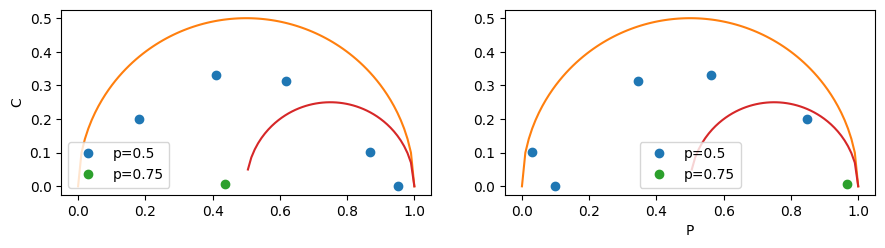

In [42]:
from common.qiskit_run import jobs_to_dm
from json import load

with open("./quantum/data/amplitude_damping.json") as f:
    exp = load(f)

fig, axes = plt.subplots(1, 2)
(ax1, ax2) = axes

vals_by_p = {}

for e in exp:
    dm = jobs_to_dm(e["jobs"])

    dm0 = partial_trace(dm, (1,))
    dm1 = partial_trace(dm, (0,))
    pol0 = polarization(dm0)
    pol1 = polarization(dm1)

    if e["p"] not in vals_by_p:        
        vals_by_p[e["p"]] = {
            "pol0_values": [],
            "con0_values": [],
            "pol1_values": [],
            "con1_values": [],
        }

    vals_by_p[e["p"]]["pol0_values"].append(pol0)
    vals_by_p[e["p"]]["con0_values"].append(concurrence(dm))
    vals_by_p[e["p"]]["pol1_values"].append(pol1)
    vals_by_p[e["p"]]["con1_values"].append(concurrence(dm))

for p, values in vals_by_p.items():
    pol0_values = values["pol0_values"]
    con0_values = values["con0_values"]
    pol1_values = values["pol1_values"]
    con1_values = values["con1_values"]
    # C and P
    ax1.plot(pol0_values, con0_values, "o", label=f"p={p}")
    ax2.plot(pol1_values, con1_values, "o", label=f"p={p}")

    # theory
    pol = np.linspace(0, 1, 100)
    c = np.sqrt((1 - p) ** 2 - (pol - p) ** 2)
    ax1.plot(pol, c)
    ax2.plot(pol, c)

ax1.set_ylabel("C")
ax2.set_xlabel("P")

for a in axes:
    a.legend()
    a.set_aspect("equal")

fig.set_size_inches(10.5, 7.5)
plt.show()